In [81]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io
import time
from joblib import dump

from sys import getsizeof
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [82]:
labels_forest = pd.read_csv(r'../data/forest_labels.csv')

In [83]:
def split_bounds_into_columns(data):
    data['Bounds'] = data['Lower bound, Upper bound'].apply(ast.literal_eval)

    # Determine the maximum number of attributes (divided by 2 because each attribute has a lower and upper bound)
    max_attributes = max(data['Bounds'].apply(len)) // 2

    for i in range(max_attributes):
        data[f'A{i+1}_lb'] = data['Bounds'].apply(lambda x: x[2*i] if 2*i < len(x) else None)
        data[f'A{i+1}_ub'] = data['Bounds'].apply(lambda x: x[2*i+1] if 2*i+1 < len(x) else None)

    data.drop(columns=['Lower bound, Upper bound', 'Bounds'], inplace=True)
    
    return data, max_attributes

In [84]:
forest_data, forst_max_attributes = split_bounds_into_columns(labels_forest)

In [85]:
def calculate_q_error(est, act):
    if act < 1 or est < 1:
        raise ValueError("Both actual and estimated selectivities should be >= 1")
    return max(est / act, act / est)

def geometric_mean_q_errors(q_errors):
    q_errors = np.array(q_errors)
    if np.any(q_errors <= 0):
        raise ValueError("Q-errors must be positive numbers")
    return np.exp(np.mean(np.log(q_errors)))

def log_transform_selectivity(selectivities):
    return np.log2(selectivities)

def inverse_log_transform(estimations):
    return 2 ** estimations

In [86]:
def fill_missing_bounds(data, max_attributes):
    for i in range(1, max_attributes + 1):
        if f'A{i}_lb' in data.columns:
            min_value = data[f'A{i}_lb'].min()
            data[f'A{i}_lb'].fillna(min_value, inplace=True)
        
        if f'A{i}_ub' in data.columns:
            max_value = data[f'A{i}_ub'].max()
            data[f'A{i}_ub'].fillna(max_value, inplace=True) 
    return data

forest_data_filled = fill_missing_bounds(forest_data.copy(), forst_max_attributes)

In [87]:
import re
def qsubprocessing(string):
    number = re.findall(r"\d+\.\d+", string)[0]  # This will find all patterns of digits followed by a decimal and digits, and select the first match
    sign = "<" not in string
    tox, sign, number = ( string.split()[0], sign, float(number))
    
    lb = 0
    ub = 1
    if sign:
        ub = number
    else:
        lb = number
        
    return {tox + "_ub": ub,
            tox + "_lb": lb}


def Qprocessing(q):
    qs = q.split("AND")
    qs[0] = qs[0].split("WHERE")[1]
    qs = list(map(qsubprocessing, qs))
    togeather = {}
    zeroone = {'elevation_ub': 1, "elevation_lb":0,'aspect_ub': 1, 'aspect_lb': 0, 'slope_ub': 1, 'slope_lb': 0, 'h_hydrology_ub': 1, 'h_hydrology_lb': 0, 'hillshade_9am_ub': 1, 'hillshade_9am_lb': 0, 'hillshade_noon_ub': 1, 'hillshade_noon_lb': 0, 'hillshade_3pm_ub': 1, 'hillshade_3pm_lb': 0, 'h_fire_points_ub': 1, 'h_fire_points_lb': 0, 'v_hydrology_ub': 1,	'v_hydrology_lb': 0,	'h_roadways_ub': 1,	'h_roadways_lb': 0}
    for q in qs:
        togeather = {**togeather, **q}
    return {**zeroone,**togeather}



In [88]:
df =pd.DataFrame(list(map(Qprocessing,labels_forest["Query"])))

In [89]:
df['Label'] = labels_forest["Label"]

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

class FCNN(nn.Module):
    def __init__(self, layers=[4,5,5,1]):
        super(FCNN, self).__init__()
        self.input_dim = layers[0]
        self.hidden_layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-2)])
        self.output_layer = nn.Linear(layers[-2], layers[-1])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden_layers[0](x))
        for layer in self.hidden_layers[1:]:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

    def fit(self, X_train, y_train_transformed, epochs=100, learning_rate=0.01):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_transformed.values, dtype=torch.float32)
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            output = self(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

            if epoch % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    def predict(self, X_test):
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
            output = self(X_test_tensor).numpy()
            output[output<0] = 0
            return output

In [91]:
import numpy as np
import pandas as pd

class AVI:
    def fit(self, X_train, y_train_transformed):
        self.k = max(y_train_transformed) - min(y_train_transformed)
        self.b = min(y_train_transformed)

    def predict(self, X_test):
        upper_bound_columns = [col for col in df.columns if col.endswith('_ub')]
        lower_bound_columns = [col for col in df.columns if col.endswith('_lb')]
        upper_product = X_test[upper_bound_columns].prod(axis=1)
        lower_product = (1 - X_test[lower_bound_columns]).prod(axis=1)
        answer = upper_product * lower_product
        return answer*self.k+self.b

In [92]:
def evaluate_models_extended(X_train, y_train_transformed, X_test, y_test_transformed, models):
    extended_results = {}
    extended_results_train = {}
    for name, model in models.items():
        model.fit(X_train, y_train_transformed)
        y_pred_transformed = model.predict(X_test)
        y_pred_transformed[y_pred_transformed < 0] = 0

        y_test = inverse_log_transform(y_test_transformed)
        y_pred = inverse_log_transform(y_pred_transformed)

        q_errors = [calculate_q_error(est, act) for est, act in zip(y_pred, y_test)]
        geom_mean_q_error = geometric_mean_q_errors(q_errors)
        mse = mean_squared_error(y_test_transformed, y_pred_transformed)
        r2 = r2_score(y_test_transformed, y_pred_transformed)
        memory_usage = getsizeof(model)
        
        
        extended_results[name] = {
            'MSE': mse,
            'R2 Score': r2,
            'Geometric Mean Q-Error': geom_mean_q_error,
            'Memory Usage (KB)': memory_usage / 1024,
            'Model': model
        }
        
        y_pred_transformed = model.predict(X_train)
        y_pred_transformed[y_pred_transformed < 0] = 0
        mse = mean_squared_error(y_train_transformed, y_pred_transformed)
        r2 = r2_score(y_train_transformed, y_pred_transformed)
        y_train = inverse_log_transform(y_train_transformed)
        q_errors = [calculate_q_error(est, act) for est, act in zip(y_pred, y_train)]
        geom_mean_q_error = geometric_mean_q_errors(q_errors)
        
        extended_results_train[name] = {
            'MSE': mse,
            'R2 Score': r2,
            'Geometric Mean Q-Error': geom_mean_q_error,
        }
    return extended_results, extended_results_train

In [93]:
def prepare_data_for_training(data):
    optional_columns = ['planning_time_ms', 'execution_time_ms', 'estimated_selectivity_avi', 'estimated_selectivity_stholes', 
                        'A5_lb', 'A5_ub', 'A6_lb', 'A6_ub', 'A7_lb', 'A7_ub']

    more_columns = ['A8_lb', 'A8_ub', 'A9_lb', 'A9_ub']
    
    if all(col in data.columns for col in more_columns):
        optional_columns.extend(more_columns)
    
    base_drop_columns = ['Query number', 'Query', 'query', 'Label']
    columns_to_drop = base_drop_columns + optional_columns
    global X
    global y
    X = data.drop(columns=[col for col in columns_to_drop if col in data.columns])
    y = data['Label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    y_train_transformed = log_transform_selectivity(y_train + 1)
    y_test_transformed = log_transform_selectivity(y_test + 1)

    return X_train, X_test, y_train_transformed, y_test_transformed


In [94]:
def get_model_size(model):
    buffer = io.BytesIO()
    dump(model, buffer)
    size = buffer.tell()
    return size / 1024  # size in kilobytes

In [95]:
X_train_forest, X_test_forest, y_train_transformed_forest, y_test_transformed_forest = prepare_data_for_training(df.sample(n=10000))

In [96]:
models = {
    'AVI':AVI(),
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(random_state=42),
    "FCNN": FCNN(layers = [20, 100, 100, 1]),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=10, random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'K-Neighbors Regressor': KNeighborsRegressor(),
}

In [97]:
results_forest, results_forest_train = evaluate_models_extended(
    X_train = X_train_forest, 
    X_test = X_test_forest, 
    y_train_transformed = y_train_transformed_forest, 
    y_test_transformed = y_test_transformed_forest, 
    models = models
)

/Users/lianadarbinyan/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8000])) that is different to the input size (torch.Size([8000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Loss: 80.1250
Epoch [11/100], Loss: 44.9706
Epoch [21/100], Loss: 45.7339
Epoch [31/100], Loss: 44.5601
Epoch [41/100], Loss: 44.2551
Epoch [51/100], Loss: 44.2000
Epoch [61/100], Loss: 44.1821
Epoch [71/100], Loss: 44.1490
Epoch [81/100], Loss: 44.1409
Epoch [91/100], Loss: 44.1313


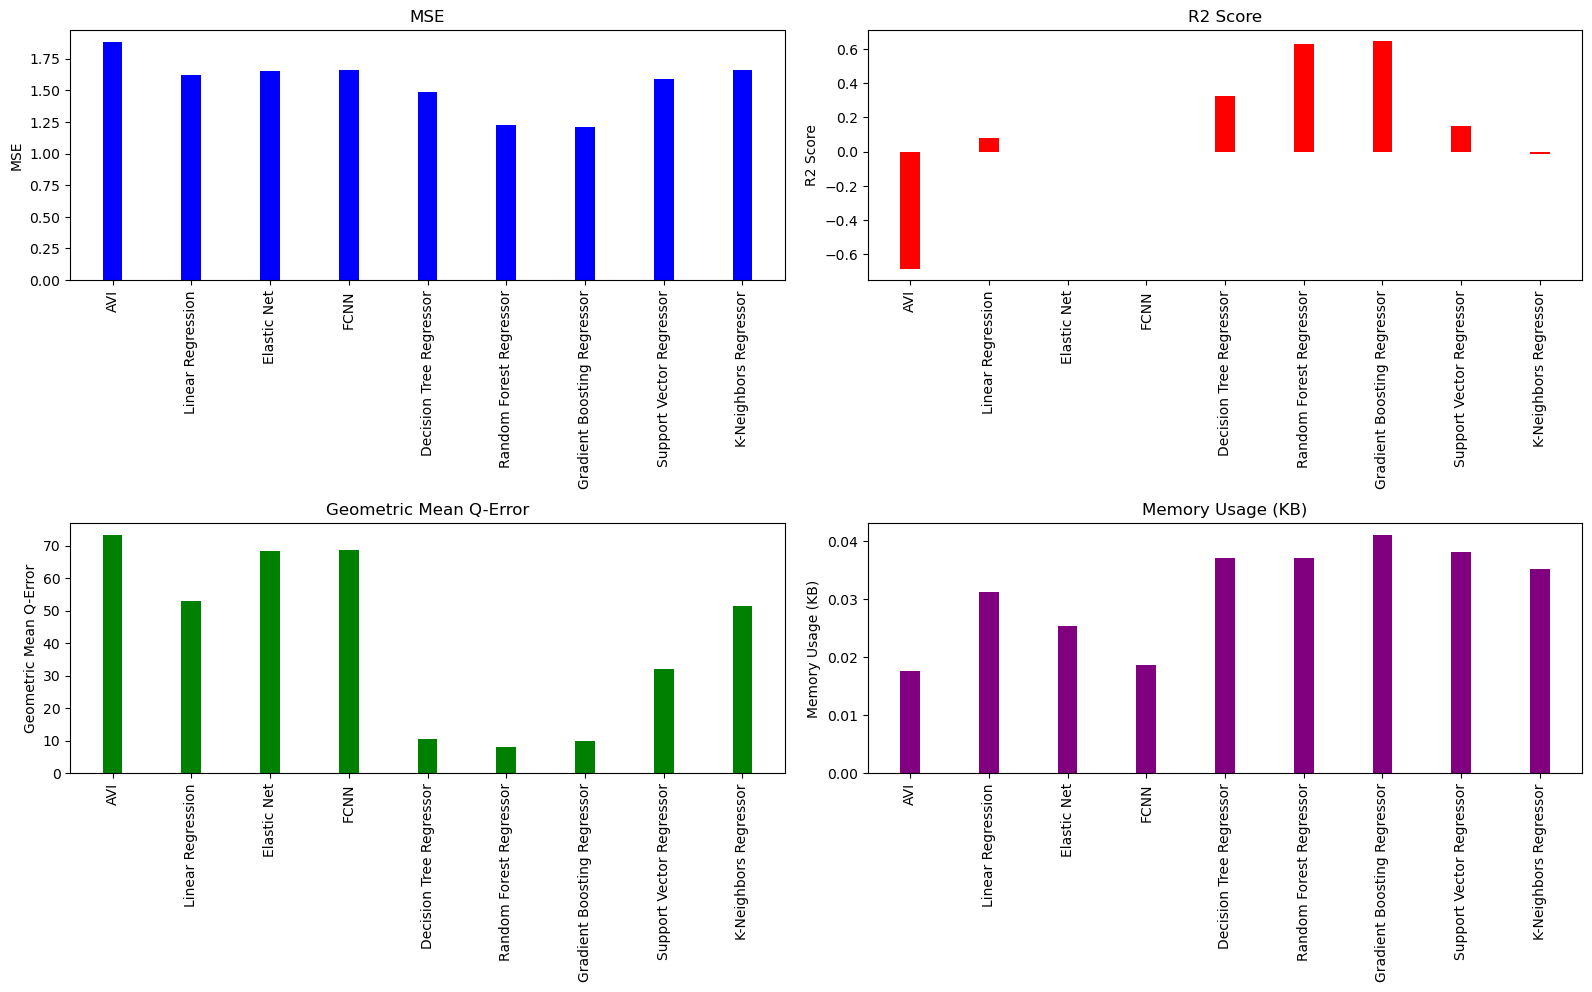

In [98]:
models = list(results_forest.keys())
log_mse = [np.log10(results_forest[model]['MSE']) for model in models]
r2_scores = [results_forest[model]['R2 Score'] for model in models] # [-np.log10(abs(results_forest[model]['R2 Score']) + 1) * (-1 if results_forest[model]['R2 Score'] < 0 else 1) for model in models]
q_errors = [results_forest[model]['Geometric Mean Q-Error'] for model in models]
memory_usage = [get_model_size(model) for model in models]

fig, ax = plt.subplots(2, 2, figsize=(16, 10))
bar_width = 0.25 

index = np.arange(len(models))

ax[0, 0].bar(index, log_mse, color='b', width=bar_width)
ax[0, 0].set_title('MSE')
ax[0, 0].set_xticks(index)
ax[0, 0].set_xticklabels(models, rotation=90)
ax[0, 0].set_ylabel('MSE')

ax[0, 1].bar(index, r2_scores, color='r', width=bar_width)
ax[0, 1].set_title('R2 Score')
ax[0, 1].set_xticks(index)
ax[0, 1].set_xticklabels(models, rotation=90)
ax[0, 1].set_ylabel('R2 Score')

ax[1, 0].bar(index, q_errors, color='g', width=bar_width)
ax[1, 0].set_title('Geometric Mean Q-Error')
ax[1, 0].set_xticks(index)
ax[1, 0].set_xticklabels(models, rotation=90)
ax[1, 0].set_ylabel('Geometric Mean Q-Error')

ax[1, 1].bar(index, memory_usage, color='purple', width=bar_width)
ax[1, 1].set_title('Memory Usage (KB)')
ax[1, 1].set_xticks(index)
ax[1, 1].set_xticklabels(models, rotation=90)
ax[1, 1].set_ylabel('Memory Usage (KB)')

plt.tight_layout(pad=1.0)
plt.show()

/var/folders/p1/kz56n2kx6x707zzb5w80z1fr0000gn/T/ipykernel_50042/1425455957.py:2: RuntimeWarning: divide by zero encountered in log10
  log_mse = [np.log10(results_forest_train[model]['MSE']) for model in models]


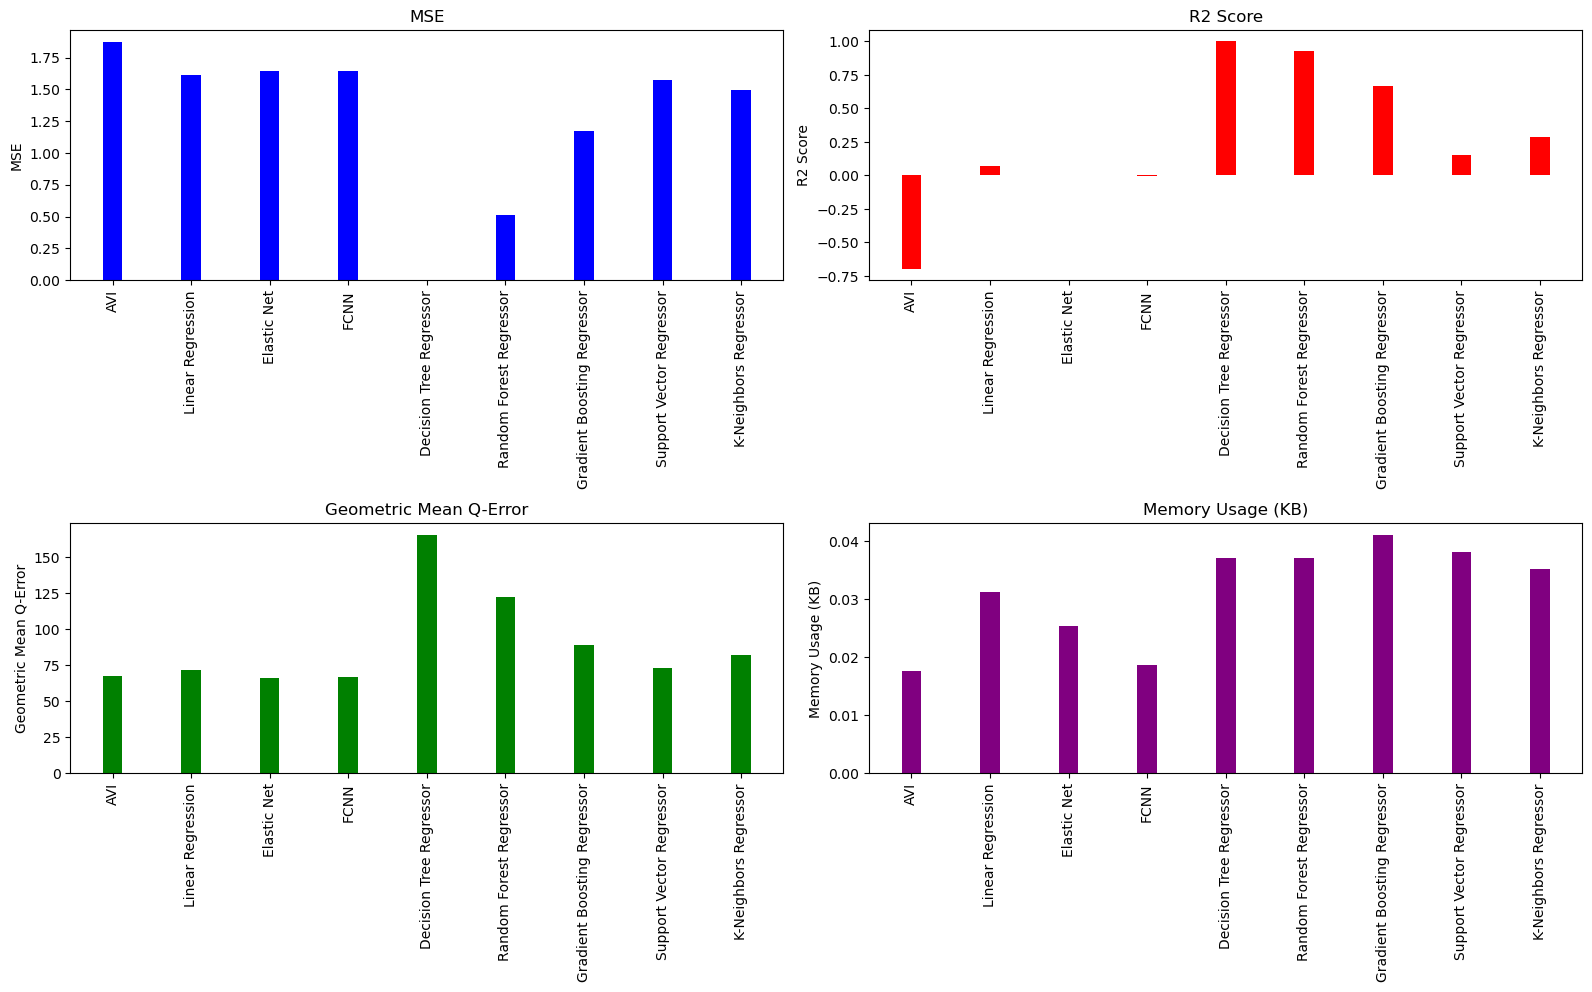

In [99]:
models = list(results_forest_train.keys())
log_mse = [np.log10(results_forest_train[model]['MSE']) for model in models]
r2_scores = [results_forest_train[model]['R2 Score'] for model in models] # [-np.log10(abs(results_forest[model]['R2 Score']) + 1) * (-1 if results_forest[model]['R2 Score'] < 0 else 1) for model in models]
q_errors = [results_forest_train[model]['Geometric Mean Q-Error'] for model in models]
memory_usage = [get_model_size(model) for model in models]

fig, ax = plt.subplots(2, 2, figsize=(16, 10))
bar_width = 0.25 

index = np.arange(len(models))

ax[0, 0].bar(index, log_mse, color='b', width=bar_width)
ax[0, 0].set_title('MSE')
ax[0, 0].set_xticks(index)
ax[0, 0].set_xticklabels(models, rotation=90)
ax[0, 0].set_ylabel('MSE')

ax[0, 1].bar(index, r2_scores, color='r', width=bar_width)
ax[0, 1].set_title('R2 Score')
ax[0, 1].set_xticks(index)
ax[0, 1].set_xticklabels(models, rotation=90)
ax[0, 1].set_ylabel('R2 Score')

ax[1, 0].bar(index, q_errors, color='g', width=bar_width)
ax[1, 0].set_title('Geometric Mean Q-Error')
ax[1, 0].set_xticks(index)
ax[1, 0].set_xticklabels(models, rotation=90)
ax[1, 0].set_ylabel('Geometric Mean Q-Error')

ax[1, 1].bar(index, memory_usage, color='purple', width=bar_width)
ax[1, 1].set_title('Memory Usage (KB)')
ax[1, 1].set_xticks(index)
ax[1, 1].set_xticklabels(models, rotation=90)
ax[1, 1].set_ylabel('Memory Usage (KB)')

plt.tight_layout(pad=1.0)
plt.show()

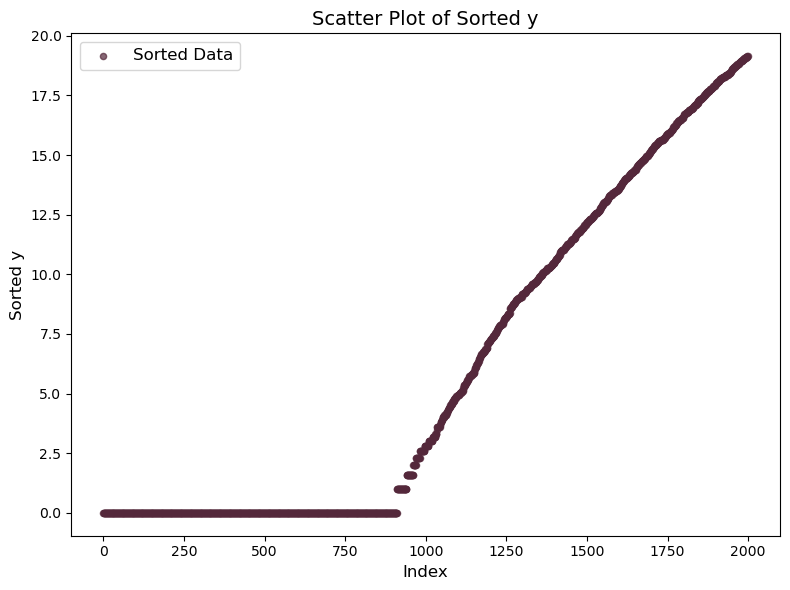

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Sort y_test_transformed_forest in ascending order
sorted_y_test = np.sort(y_test_transformed_forest)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(sorted_y_test)), sorted_y_test, s=20, c='#54283b', alpha=0.7, label="Sorted Data")
plt.xlabel("Index", fontsize=12)
plt.ylabel("Sorted y", fontsize=12)
plt.title("Scatter Plot of Sorted y", fontsize=14)
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

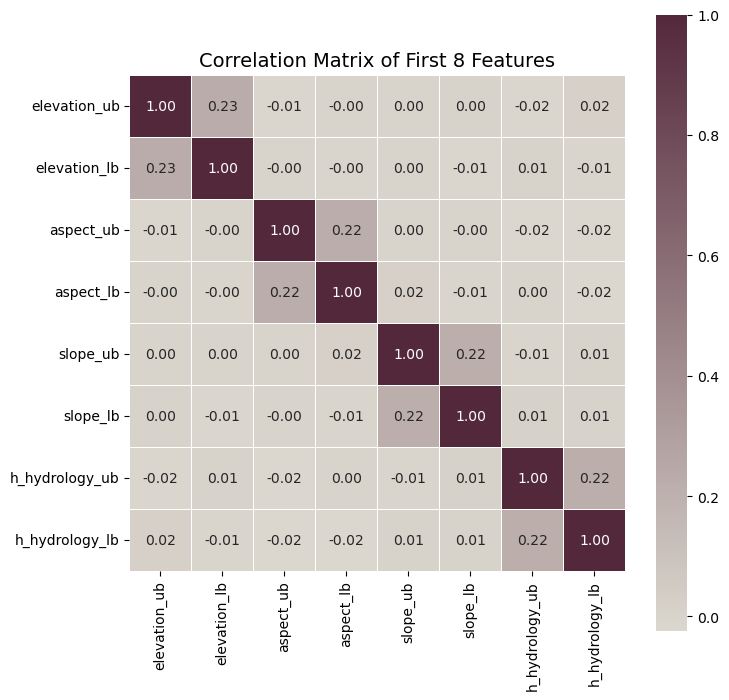

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Calculate correlation matrix
corr_matrix = X.corr()

# Define custom colors
dark_red = "#54283b"
dark_milk = "#dbd7ce"

# Create custom colormap
colors = [dark_milk, dark_red]
cmap = LinearSegmentedColormap.from_list("Custom", colors)

# Plotting the correlation matrix of the first 8 features
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix.iloc[:8, :8], annot=True, cmap=cmap, fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Matrix of First 8 Features', fontsize=14)
plt.show()


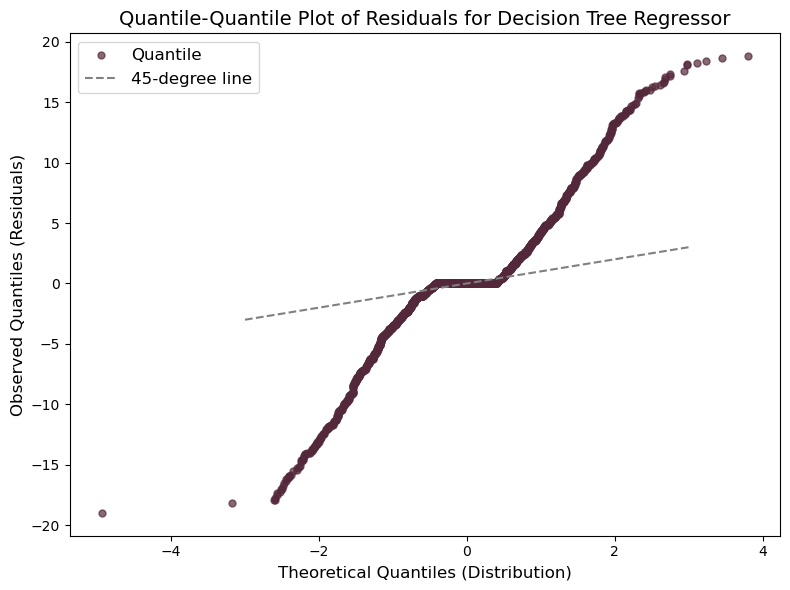

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

res = y_test_transformed_forest - results_forest['Decision Tree Regressor']['Model'].predict(X_test_forest)

quantiles = np.linspace(0, 100, len(y_test_transformed_forest))
q_observed, q_theoretical = np.percentile(res, quantiles), np.percentile(np.random.normal(0, 1, len(y_test_transformed_forest)), quantiles)

plt.figure(figsize=(8, 6))
plt.plot(q_theoretical, q_observed, ls="", marker="o", markersize=5, color="#54283b", alpha=0.7, label="Quantile")
plt.plot([-3, 3], [-3, 3], ls="--", color="gray", label="45-degree line")  # 45-degree line
plt.xlabel("Theoretical Quantiles (Distribution)", fontsize=12)
plt.ylabel("Observed Quantiles (Residuals)", fontsize=12)
plt.title("Quantile-Quantile Plot of Residuals for Decision Tree Regressor", fontsize=14)
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()
